In [100]:
import numpy as np
from numpy.linalg import inv
import scipy as sci
import control
from scipy.signal import place_poles, StateSpace, lsim
import matplotlib.pyplot as plt
from sim import *
pi = np.pi


In [101]:
## Define SS

RE = 6378 # km
ROrb = 300 # km
r0 = RE + ROrb
mu = 398600


A = np.array([[           0, 1, 0,                0],
                [3*mu/(r0**3), 0, 0, 2*np.sqrt(mu/r0)],
                [ 0, 0, 0, 1],
                [0, -2*np.sqrt(mu/r0**5), 0, 0 ]])

B = np.array([[0,0],
                [1,0],
                [0,0],
                [0,1/r0]])

C = np.array([[1,0,0,0],[0,0,1,0]])

D = np.zeros([2,2])




In [102]:
## Define Reference Input and Constant Disturbance force

# Period of orbit
T = 2*pi*np.sqrt(r0**3/mu)

# Define simulation time to be 3 orbital periods
tvec = np.linspace(0,3*T,round(30*T))

omega_des = np.sqrt(mu/(r0**3))


# Define reference input
#ref = np.vstack((np.zeros(len(tvec)), omega_des * tvec))
ref = np.zeros(len(tvec))

# Define a disturbance profile
d = np.zeros([2,len(tvec)])

# For now, random constant disturbance
f = 4000
d[1,:] = -0.0001


G = np.array([[0,0],[1,0],[0,0],[0,1]])



System is reachable 



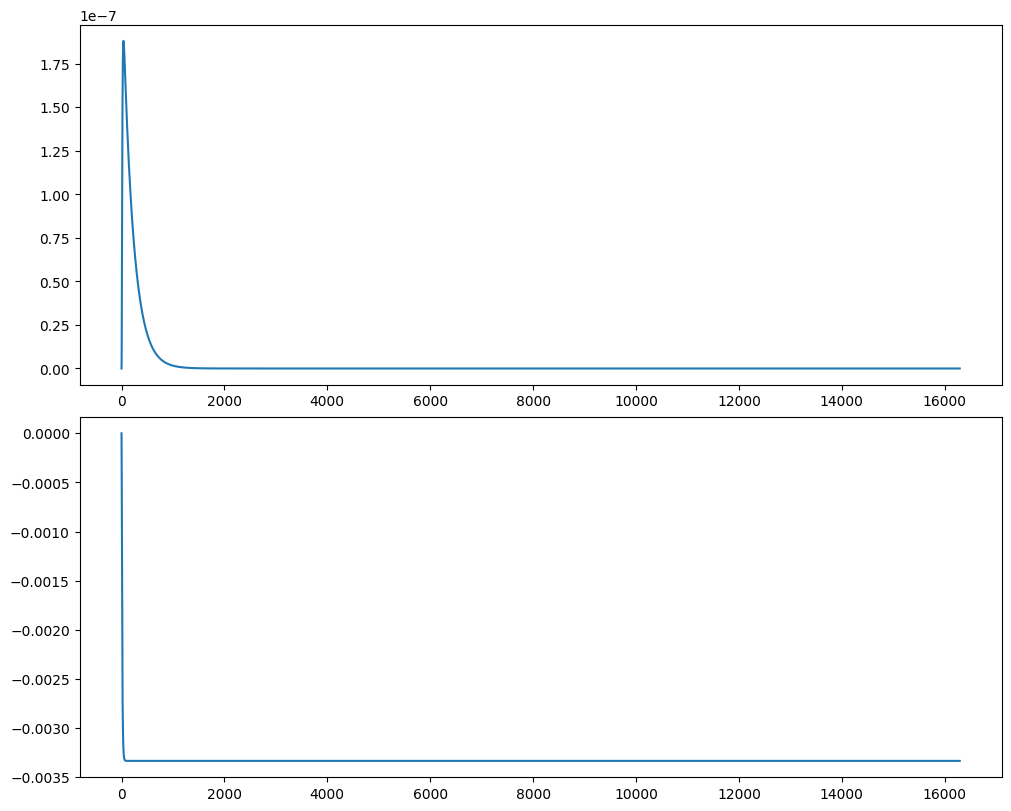

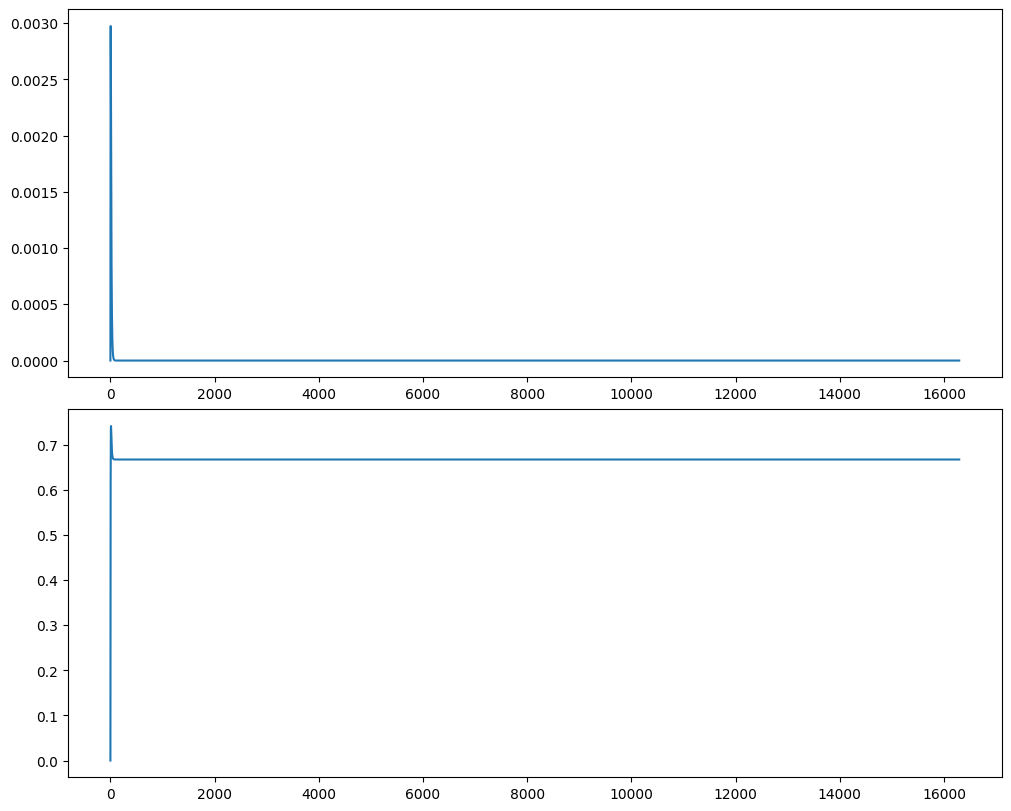

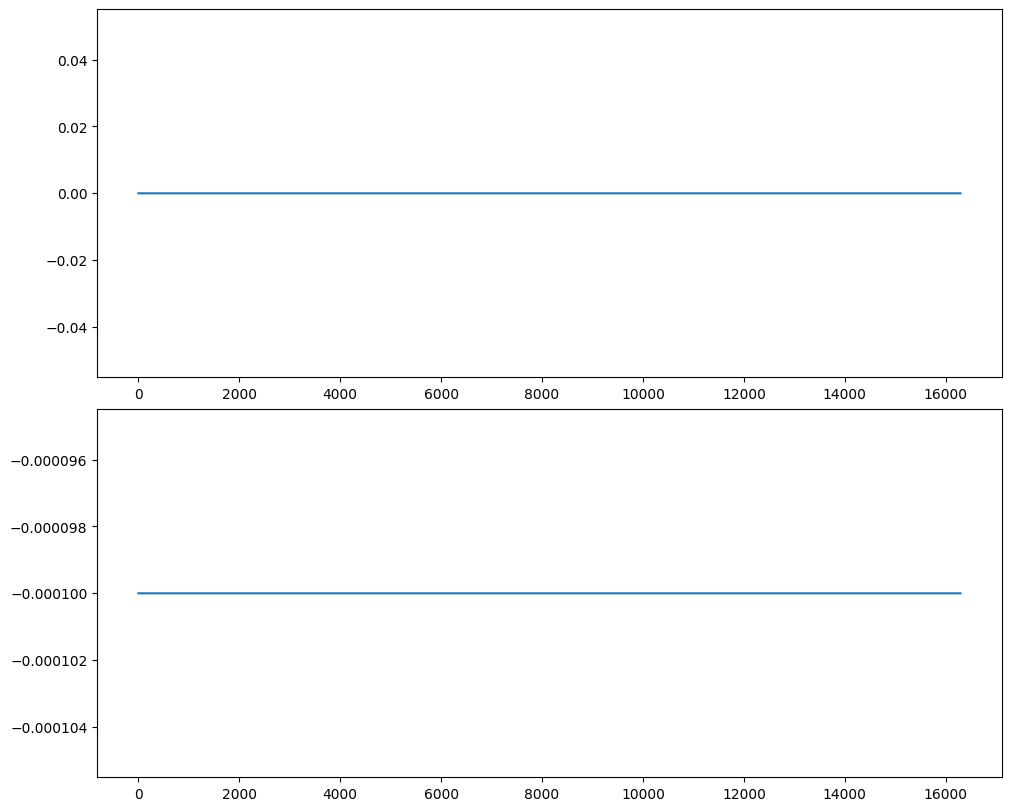

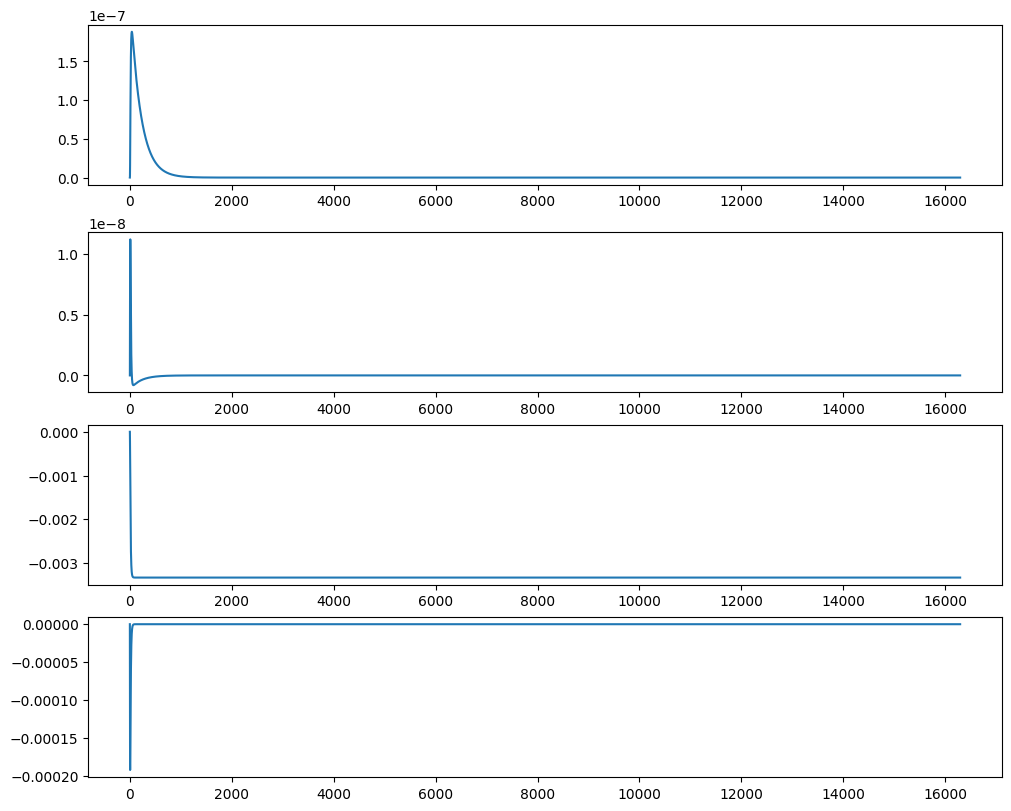

In [105]:
## Integral Controller
# New state: x_aug = [x; x_I]

Cr = np.array([1,0,0,0]) # C reference, only want to control radius (only reference input)

AaugOL = np.block([[A, np.zeros([4,1])],[-Cr, np.zeros(1)]])
BaugOL = np.block([[B],[np.zeros([1,2])]])
CaugOL = np.block([C, np.zeros([2,1])])
DaugOL = D

# Check reachability of system
P = control.ctrb(AaugOL,BaugOL)

r = np.linalg.matrix_rank(P)
n_states = AaugOL.shape[0]

if n_states == r:
    print("System is reachable \n")

des_poles = np.array([-0.005,-0.1,-0.2,-0.3,-0.4])

res = place_poles(AaugOL,BaugOL,des_poles)
Ka = res.gain_matrix

AaugCL = AaugOL - BaugOL@Ka
BaugCL = np.block([[G],[np.zeros([1,2])]])

sys = StateSpace(AaugCL,BaugCL,CaugOL,DaugOL)

thist, yhist, xhist = lsim(sys, U = d.T, T = tvec)

# Compute resulting control response
U = -Ka@xhist.T

fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(thist,yhist[:,0])
ax[1].plot(thist,yhist[:,1])

fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(thist,U[0,:])
ax[1].plot(thist,U[1,:])

fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(thist,d[0,:])
ax[1].plot(thist,d[1,:])

fig, ax = plt.subplots(4,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(thist,xhist[:,0])
ax[1].plot(thist,xhist[:,1])
ax[2].plot(thist,xhist[:,2])
ax[3].plot(thist,xhist[:,3])